In [100]:
# Copy this file and then run an experiment
# Import modules
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import importlib
import pickle  # Use this to save results so we don't need to rerun experiments
rf = importlib.import_module("random-forests")
misclass_rate = rf.random_forests.misclassification_rate
cmap = {"iris": "blue", "wine": "purple", "heart": "red", "titanic": "green", "breast": "orange"}
def comp_mean_sd(arr):
    return np.array([np.mean(arr), np.std(arr)])
def get_mean_sd(results):
    ret = {}
    for k in results.keys():
        ret[k] = np.apply_along_axis(comp_mean_sd, 1, results[k])
    return ret

In [101]:
# Load all datasets to use
mushroom = np.loadtxt("agaricus-lepiota.data", dtype=str, delimiter=",")
wine = np.loadtxt("wine.data", delimiter=",")
iris = np.loadtxt("iris_csv.csv", dtype=str, delimiter=",")
heart = np.loadtxt("processed.cleveland.data", dtype=str, delimiter=",")
titanic = pd.read_csv("titanic.csv").drop(columns=["PassengerId", "Name", "Ticket", "Cabin"]).dropna()
breast = np.loadtxt("breast-cancer.data", delimiter=",", dtype=str)

In [102]:
# Clean data
def str_in_arr(arr, str):
    return not np.isin(str, arr)
barr_mushroom = np.apply_along_axis(str_in_arr, 1, mushroom, "?")
mushroom = mushroom[barr_mushroom, :]
barr_breast = np.apply_along_axis(str_in_arr, 1, breast, "?")
breast = breast[barr_breast, :]
barr_heart = np.apply_along_axis(str_in_arr, 1, heart, "?")
heart = heart[barr_heart, :]
heart = heart.astype(float)

In [103]:
# Separate into data and labels
iris_data = iris[1:, :4].astype(float)
iris_labels = iris[1:, 4]
wine_data = wine[:, 1:]
wine_labels = wine[:, 0].astype(int)
heart_data = heart[:, :-1]
heart_labels = heart[:, -1].astype(int)
# Turn heart_labels into array of 0, 1.
# 1 indicates presence of any type of heart disease, 0 indicates no presence
heart_labels_barr = heart_labels >= 1
heart_labels[heart_labels_barr] = 1
mushroom_data = mushroom[:, 1:]
mushroom_labels = mushroom[:, 0]
breast_data = breast[:, 1:]
breast_labels = breast[:, 0]
titanic_data = titanic.loc[:, titanic.columns!="Survived"].to_numpy()  # feature_type: complex
titanic_labels = titanic["Survived"].to_numpy()

In [104]:
# Record the feature types
iris_ftype = "continuous"
heart_ftype = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])
wine_ftype = "continuous"
mushroom_ftype = "categorical"
breast_ftype = "categorical"
titanic_ftype = np.array([1, 1, 0, 0, 0, 0, 1])

In [105]:
# Set the seed so test train split it always the same for all tests
np.random.seed(1)
datasets = {"iris": (*train_test_split(iris_data, iris_labels, stratify=iris_labels), "continuous"),
            "wine": (*train_test_split(wine_data, wine_labels, stratify=wine_labels), "continuous"),
            "heart": (*train_test_split(heart_data, heart_labels, stratify=heart_labels), heart_ftype),
            "mushroom": (*train_test_split(mushroom_data, mushroom_labels, stratify=mushroom_labels), "categorical"),
            "titanic": (*train_test_split(titanic_data, titanic_labels, stratify=titanic_labels), titanic_ftype),
            "breast" : (*train_test_split(breast_data, breast_labels, stratify=breast_labels), "categorical")}

In [120]:
X_train, X_test, y_train, y_test, heart_ftype = datasets["heart"]
X_train_df = pd.DataFrame(X_train, columns=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"])
X_train_df.iloc[:, heart_ftype.astype(bool)] = X_train_df.iloc[:, heart_ftype.astype(bool)].astype("category")
X_test_df = pd.DataFrame(X_test, columns=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"])
X_test_df.iloc[:, heart_ftype.astype(bool)] = X_test_df.iloc[:, heart_ftype.astype(bool)].astype("category")
datasets["heart_df"] = (X_train_df, X_test_df, y_train, y_test, heart_ftype)

In [107]:
po = open("vary_n_trees_breast.pickle", "rb")
results = pickle.load(po)
po.close()

In [108]:
ntrees = np.arange(1, 21)
nexp = 10

In [129]:
X_train, X_test, y_train, y_test, ftype = datasets["heart_df"]
result = np.empty((len(ntrees), nexp), dtype=float)
m_feats = int(np.floor(np.sqrt(X_train.shape[1])))
n_cand = 3*m_feats
np.random.seed(1)
for i, ntree in enumerate(ntrees):
    for j in range(nexp):
        boost = XGBClassifier(n_estimators=ntree, max_depth=2, enable_categorical=True, tree_method="approx")
        boost.fit(X_train, y_train)
        result[i, j] = misclass_rate(boost.predict(X_test), y_test)
results["heart_boost"] = result

In [166]:
X_train, X_test, y_train, y_test, ftype = datasets["iris"]
result = np.empty(len(ntrees), dtype=float)
np.random.seed(1)
for i, ntree in enumerate(ntrees):
    boost = XGBClassifier(n_estimators=ntree, max_depth=2, tree_method="approx")
    boost.fit(X_train, encode(y_train))
    result[i] = misclass_rate(boost.predict(X_test), encode(y_test))
results["iris_boost"] = result

In [165]:
def encode(y):
    labels = list(np.unique(y))
    labels.sort()
    ret = np.zeros(len(y), dtype=int)
    for i, label in enumerate(labels):
        barr = y == label
        ret[barr] = i
    return ret

In [170]:
X_train, X_test, y_train, y_test, ftype = datasets["breast"]
X_train_df = pd.DataFrame(X_train).astype("category")
X_test_df = pd.DataFrame(X_test).astype("category")
datasets["breast_df"] = (X_train_df, X_test_df, encode(y_train), encode(y_test), ftype)

In [174]:
X_train, X_test, y_train, y_test, ftype = datasets["breast_df"]
result = np.empty(len(ntrees), dtype=float)
np.random.seed(1)
for i, ntree in enumerate(ntrees):
    boost = XGBClassifier(n_estimators=ntree, max_depth=2, tree_method="approx", enable_categorical=True)
    boost.fit(X_train, y_train)
    result[i] = misclass_rate(boost.predict(X_test), y_test)
results["breast_boost"] = result

In [175]:
results["breast_boost"]

array([0.27142857, 0.22857143, 0.25714286, 0.24285714, 0.25714286,
       0.25714286, 0.25714286, 0.27142857, 0.25714286, 0.27142857,
       0.27142857, 0.27142857, 0.27142857, 0.27142857, 0.27142857,
       0.27142857, 0.27142857, 0.27142857, 0.27142857, 0.25714286])

In [176]:
results.keys()

dict_keys(['iris', 'wine', 'heart', 'titanic', 'mushroom', 'breast', 'titanic_boost', 'heart_boost', 'iris_boost', 'breast_boost'])

In [181]:
po = open("vary_n_trees_breast.pickle", "rb")
r2 = pickle.load(po)
po.close()

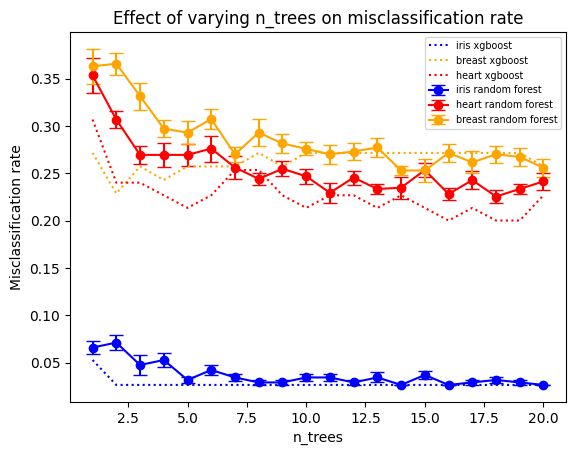

In [210]:
mean_sd = get_mean_sd(r2)
for dataset, m_sd in mean_sd.items():
    if dataset in {"mushroom", "titanic", "wine"}:
        continue
    plt.errorbar(ntrees, m_sd[:, 0], yerr=m_sd[:, 1]/np.sqrt(nexp), label=dataset + " random forest", capsize=5, fmt="o-", c=cmap[dataset])
plt.plot(ntrees, results["iris_boost"], c=cmap["iris"], linestyle=":", label="iris xgboost")
plt.plot(ntrees, results["breast_boost"], c=cmap["breast"], linestyle=":", label= "breast xgboost")
plt.plot(ntrees, results["heart_boost"][:,0], c=cmap["heart"], linestyle=":", label="heart xgboost")
plt.xlabel("n_trees")
plt.ylabel("Misclassification rate")
plt.title("Effect of varying n_trees on misclassification rate")
plt.legend(fontsize="x-small")

In [189]:
po = open("test_boosting.pickle", "wb")
pickle.dump(results, po)
po.close()

In [ ]:
results_knn = {}

In [198]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test, ftype = datasets["wine"]
nneighbours = np.arange(1,10)
misclass_rates = np.zeros(len(nneighbours), dtype=float)
for i, n in enumerate(nneighbours):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    misclass_rates[i] = misclass_rate(neigh.predict(X_test), y_test)
misclass_rates

array([0.26666667, 0.28888889, 0.33333333, 0.4       , 0.31111111,
       0.35555556, 0.28888889, 0.35555556, 0.35555556])

In [200]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test, ftype = datasets["iris"]
nneighbours = np.arange(1,10)
misclass_rates = np.zeros(len(nneighbours), dtype=float)
for i, n in enumerate(nneighbours):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    misclass_rates[i] = misclass_rate(neigh.predict(X_test), y_test)
misclass_rates

array([0.02631579, 0.05263158, 0.02631579, 0.05263158, 0.05263158,
       0.02631579, 0.05263158, 0.05263158, 0.02631579])

In [201]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test, ftype = datasets["iris"]
nneighbours = np.arange(0.1,2.0,0.1)
misclass_rates = np.zeros(len(nneighbours), dtype=float)
for i, n in enumerate(nneighbours):
    neigh = SVC(C=n)
    neigh.fit(X_train, y_train)
    misclass_rates[i] = misclass_rate(neigh.predict(X_test), y_test)
misclass_rates

array([0.15789474, 0.10526316, 0.05263158, 0.05263158, 0.02631579,
       0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579,
       0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579,
       0.02631579, 0.02631579, 0.02631579, 0.02631579])

In [209]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test, ftype = datasets["wine"]
nneighbours = np.arange(0.1,2.0,0.1)
misclass_rates = np.zeros(len(nneighbours), dtype=float)
for i, n in enumerate(nneighbours):
    svc = SVC(C=n, degree=100)
    svc.fit(X_train, y_train)
    misclass_rates[i] = misclass_rate(svc.predict(X_test), y_test)
misclass_rates

array([0.35555556, 0.35555556, 0.35555556, 0.37777778, 0.33333333,
       0.4       , 0.37777778, 0.35555556, 0.4       , 0.37777778,
       0.35555556, 0.35555556, 0.37777778, 0.4       , 0.37777778,
       0.37777778, 0.37777778, 0.37777778, 0.37777778])

In [211]:
a, b, c, d, e = datasets["titanic"]

In [212]:
a.shape

(534, 7)